### Here we transform the NetCDF file into standard lists for further analyses 
#### We regrid the spatial resolution onto 2°×2°
#### Historical O${_3}$ simulations 2100

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import iris

#### Prescribe the key parameters: 
##### i) target years for analysis (e.g. Y = 1 for a single year 2100)
##### ii) ideal spatial resolutions (e.g. 180×90 grids)
###### These parameters are prescribed arbitrarily

In [2]:
Y = 1
lon = 180
lat = 90

#### Define the 1°×1° new spatial resolution for regridding (centred coordinates)

In [3]:
res_lon = 360/lon
res_lat = 180/lat
sample_points = [('longitude', np.linspace(0+res_lon/2, 360-res_lon/2, lon)),
                 ('latitude',  np.linspace(-90+res_lat/2, 90-res_lat/2, lat))]

In [4]:
sample_points

[('longitude',
  array([  1.,   3.,   5.,   7.,   9.,  11.,  13.,  15.,  17.,  19.,  21.,
          23.,  25.,  27.,  29.,  31.,  33.,  35.,  37.,  39.,  41.,  43.,
          45.,  47.,  49.,  51.,  53.,  55.,  57.,  59.,  61.,  63.,  65.,
          67.,  69.,  71.,  73.,  75.,  77.,  79.,  81.,  83.,  85.,  87.,
          89.,  91.,  93.,  95.,  97.,  99., 101., 103., 105., 107., 109.,
         111., 113., 115., 117., 119., 121., 123., 125., 127., 129., 131.,
         133., 135., 137., 139., 141., 143., 145., 147., 149., 151., 153.,
         155., 157., 159., 161., 163., 165., 167., 169., 171., 173., 175.,
         177., 179., 181., 183., 185., 187., 189., 191., 193., 195., 197.,
         199., 201., 203., 205., 207., 209., 211., 213., 215., 217., 219.,
         221., 223., 225., 227., 229., 231., 233., 235., 237., 239., 241.,
         243., 245., 247., 249., 251., 253., 255., 257., 259., 261., 263.,
         265., 267., 269., 271., 273., 275., 277., 279., 281., 283., 285.,
         2

#### Define the longitude-latitude-temporal sequence list

In [5]:
t = Y*12 ## Y years correspond to 12Y months 

lon_range = np.linspace(0+res_lon/2, 360-res_lon/2, lon)
lat_range = np.linspace(-90+res_lat/2, 90-res_lat/2, lat) 
t_range   = np.linspace(1, t, t) 
lat_mesh, t_mesh, lon_mesh = np.meshgrid(lat_range, t_range, lon_range) 

t_grid   = t_mesh.reshape(t*lon*lat, 1)
lon_grid = lon_mesh.reshape(t*lon*lat, 1)
lat_grid = lat_mesh.reshape(t*lon*lat, 1)

dataset = pd.DataFrame(lon_grid, columns = {'longitude'})
dataset['latitude'] = lat_grid
dataset['t'] = t_grid
dataset['loc'] = dataset['longitude']*1000+dataset['latitude']
dataset

,longitude,latitude,t,loc
0,1.0,-89.0,1.0,911.0
1,3.0,-89.0,1.0,2911.0
2,5.0,-89.0,1.0,4911.0
3,7.0,-89.0,1.0,6911.0
4,9.0,-89.0,1.0,8911.0
...,...,...,...,...
194395,351.0,89.0,12.0,351089.0
194396,353.0,89.0,12.0,353089.0
194397,355.0,89.0,12.0,355089.0
194398,357.0,89.0,12.0,357089.0


#### 1.1. Import surface/ambient O${_3}$

In [6]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/ssp126/o3_AERmon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_210001-210012.nc', 'o3')
time_seq, layer, latitude, longitude = data.shape
data = data[0:t,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
o3 = values.reshape(t*lon*lat,1)
dataset['o3'] = o3

#### 1.2. Import surface/ambient O${_3}$ production rate 

In [7]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/ssp126/o3prod_AERmon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_210001-210012.nc', 'o3prod')
time_seq, layer, latitude, longitude = data.shape
data = data[0:t,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
o3prod = values.reshape(t*lon*lat,1)
dataset['o3prod'] = o3prod

#### 1.3. Import surface/ambient O${_3}$ loss rate

In [8]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/ssp126/o3loss_AERmon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_210001-210012.nc', 'o3loss')
time_seq, layer, latitude, longitude = data.shape
data = data[0:t,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
o3loss = values.reshape(t*lon*lat,1)
dataset['o3loss'] = o3loss

#### 3.1. Import near-surface air temperature

In [9]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/ssp126/tas_Amon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_205001-210012.nc', 'tas')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
tas = values.reshape(t*lon*lat,1)
dataset['tas'] = tas

#### 3.7. Import the surface air pressure

In [10]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/ssp126/ps_AERmon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_205001-210012.nc', 'ps')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
ps = values.reshape(t*lon*lat,1)
dataset['ps'] = ps

In [11]:
dataset.to_csv('/Volumes/Database/Research/ozone-budget/UKESM1-0-LL_2100_ssp126_temp.csv', index=False)

In [12]:
dataset = pd.read_csv('/Volumes/Database/Research/ozone-budget/UKESM1-0-LL_2100_ssp126_temp.csv')

#### 4.1. Import NO${_2}$ photolysis rate

In [13]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/ssp126/jno2_AERmon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_210001-210012.nc', 'jno2')
time_seq, layer, latitude, longitude = data.shape
data = data[0:t,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
jno2 = values.reshape(t*lon*lat,1)
dataset['jno2'] = jno2

#### 4.2. Import O${_3}$→O(${^1}$D) photolysis rate

In [14]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/ssp126/photo1d_AERmon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_210001-210012.nc', 'photo1d')
time_seq, layer, latitude, longitude = data.shape
data = data[0:t,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
jo3 = values.reshape(t*lon*lat,1)
dataset['photo1d'] = jo3

#### 4.3. Import CH${_4}$ reaction loss rate

In [15]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/ssp126/lossch4_AERmon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_210001-210012.nc', 'lossch4')
time_seq, layer, latitude, longitude = data.shape
data = data[0:t,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
lossch4 = values.reshape(t*lon*lat,1)
dataset['lossch4'] = lossch4

#### 4.4. Import CO reaction loss rate

In [16]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/ssp126/lossco_AERmon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_210001-210012.nc', 'lossco')
time_seq, layer, latitude, longitude = data.shape
data = data[0:t,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
lossco = values.reshape(t*lon*lat,1)
dataset['lossco'] = lossco

#### 5.1. Import NO${_2}$ concentration

In [17]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/ssp126/no2_AERmon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_210001-210012.nc', 'no2')
time_seq, layer, latitude, longitude = data.shape
data = data[0:t,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
no2 = values.reshape(t*lon*lat,1)
dataset['no2'] = no2

#### 5.2. Import NO concentration

In [18]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/ssp126/no_AERmon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_210001-210012.nc', 'no')
time_seq, layer, latitude, longitude = data.shape
data = data[0:t,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
no = values.reshape(t*lon*lat,1)
dataset['no'] = no

#### 5.3. Import OH radical concentration

In [19]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/ssp126/oh_AERmon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_210001-210012.nc', 'oh')
time_seq, layer, latitude, longitude = data.shape
data = data[0:t,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
oh = values.reshape(t*lon*lat,1)
dataset['oh'] = oh

#### 5.4. Import H${_2}$O concentration

In [20]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/ssp370/h2o_AERmon_CESM2-WACCM_ssp370_r1i1p1f1_gn_206501-210012.nc', 'h2o')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,69,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
h2o = values.reshape(t*lon*lat,1)
dataset['h2o'] = h2o

#### 5.7. Import CO concentration

In [21]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/ssp126/co_AERmon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_210001-210012.nc', 'co')
time_seq, layer, latitude, longitude = data.shape
data = data[0:t,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
co = values.reshape(t*lon*lat,1)
dataset['co'] = co

#### 5.8. Import HCHO concentration

In [22]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/ssp126/hcho_AERmon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_210001-210012.nc', 'hcho')
time_seq, layer, latitude, longitude = data.shape
data = data[0:t,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
hcho = values.reshape(t*lon*lat,1)
dataset['hcho'] = hcho

#### 5.10. Import C${_2}$H${_6}$ concentration

In [23]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/ssp126/c2h6_AERmon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_210001-210012.nc', 'c2h6')
time_seq, layer, latitude, longitude = data.shape
data = data[0:t,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
c2h6 = values.reshape(t*lon*lat,1)
dataset['c2h6'] = c2h6

#### 5.11. Import C${_3}$H${_8}$ concentration

In [24]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/ssp126/c3h8_AERmon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_210001-210012.nc', 'c3h8')
time_seq, layer, latitude, longitude = data.shape
data = data[0:t,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
c3h8 = values.reshape(t*lon*lat,1)
dataset['c3h8'] = c3h8

#### 5.12. Import C${_5}$H${_8}$ isoprene concentration

In [25]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/ssp126/isop_AERmon_UKESM1-0-LL_ssp126_r1i1p1f2_gn_210001-210012.nc', 'isop')
time_seq, layer, latitude, longitude = data.shape
data = data[0:t,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
isop = values.reshape(t*lon*lat,1)
dataset['isop'] = isop

In [26]:
dataset.to_csv('/Volumes/Database/Research/ozone-budget/UKESM1-0-LL_2100_ssp126_temp.csv', index=False)

In [27]:
dataset = pd.read_csv('/Volumes/Database/Research/ozone-budget/UKESM1-0-LL_2100_ssp126_temp.csv')

#### We should convert 0-360° into 180°W-180°E scheme

In [28]:
dataset_pt1 = dataset[dataset['longitude'] < 180]
dataset_pt2 = dataset[dataset['longitude'] >= 180]
dataset_pt2['longitude'] = dataset_pt2['longitude']-360
dataset_adj = dataset_pt1.append(dataset_pt2)
dataset_adj

,longitude,latitude,t,loc,o3,o3prod,o3loss,tas,ps,jno2,...,lossco,no2,no,oh,h2o,co,hcho,c2h6,c3h8,isop
0,1.0,-89.0,1.0,911.0,1.259995e-08,5.775880e-14,5.841876e-14,250.11797,69640.77,0.010055,...,8.177991e-14,6.161250e-13,2.252389e-12,1.872350e-14,0.001195,3.165535e-08,1.193316e-11,9.234978e-10,3.245738e-11,2.341488e-29
1,3.0,-89.0,1.0,2911.0,1.261883e-08,5.784860e-14,5.854385e-14,250.09601,69609.45,0.010053,...,8.189496e-14,6.178182e-13,2.255257e-12,1.875576e-14,0.001193,3.165273e-08,1.194696e-11,9.234399e-10,3.241845e-11,2.254809e-29
2,5.0,-89.0,1.0,4911.0,1.264293e-08,5.795349e-14,5.865586e-14,250.09512,69577.53,0.010055,...,8.195695e-14,6.200797e-13,2.259683e-12,1.879386e-14,0.001190,3.165075e-08,1.195279e-11,9.234221e-10,3.239422e-11,9.451525e-30
3,7.0,-89.0,1.0,6911.0,1.265455e-08,5.797482e-14,5.864908e-14,250.07486,69545.12,0.010054,...,8.191733e-14,6.216752e-13,2.263730e-12,1.880635e-14,0.001187,3.164917e-08,1.193268e-11,9.234166e-10,3.237296e-11,5.280114e-30
4,9.0,-89.0,1.0,8911.0,1.267726e-08,5.805373e-14,5.871303e-14,250.06026,69512.24,0.010047,...,8.196446e-14,6.236062e-13,2.267689e-12,1.883548e-14,0.001184,3.164778e-08,1.194343e-11,9.234142e-10,3.235576e-11,4.161663e-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194395,-9.0,89.0,12.0,351089.0,2.117563e-08,1.143866e-15,1.602463e-15,265.29437,101438.76,0.000000,...,9.249600e-16,1.910357e-11,5.502838e-12,5.251492e-17,0.002228,4.862844e-08,9.018454e-12,1.187709e-09,1.525426e-10,6.670628e-14
194396,-7.0,89.0,12.0,353089.0,2.120360e-08,7.698027e-16,1.425248e-15,265.33334,101442.57,0.000000,...,7.898313e-16,1.863584e-11,2.376864e-12,5.067576e-17,0.002232,4.863285e-08,9.030440e-12,1.187637e-09,1.523275e-10,6.669411e-14
194397,-5.0,89.0,12.0,355089.0,2.123404e-08,7.061948e-16,1.401246e-15,265.38270,101446.39,0.000000,...,7.713320e-16,1.936341e-11,1.487731e-12,5.154445e-17,0.002236,4.863758e-08,9.056793e-12,1.187756e-09,1.523631e-10,6.672699e-14
194398,-3.0,89.0,12.0,357089.0,2.126729e-08,8.151892e-16,1.440704e-15,265.43900,101450.20,0.000000,...,8.036410e-16,2.058845e-11,1.986619e-12,5.319611e-17,0.002238,4.864218e-08,9.092588e-12,1.187993e-09,1.525369e-10,6.679152e-14


In [29]:
dataset_adj.to_csv('/Users/csuen/Desktop/Sun-NG-24/radicals/UKESM1-0-LL_2100_ssp126(ver240112).csv', index=False)

In [30]:
list(dataset_adj)

['longitude',
 'latitude',
 't',
 'loc',
 'o3',
 'o3prod',
 'o3loss',
 'tas',
 'ps',
 'jno2',
 'photo1d',
 'lossch4',
 'lossco',
 'no2',
 'no',
 'oh',
 'h2o',
 'co',
 'hcho',
 'c2h6',
 'c3h8',
 'isop']

### Map the variables to ensure correct gridding

(-90.0, 90.0)

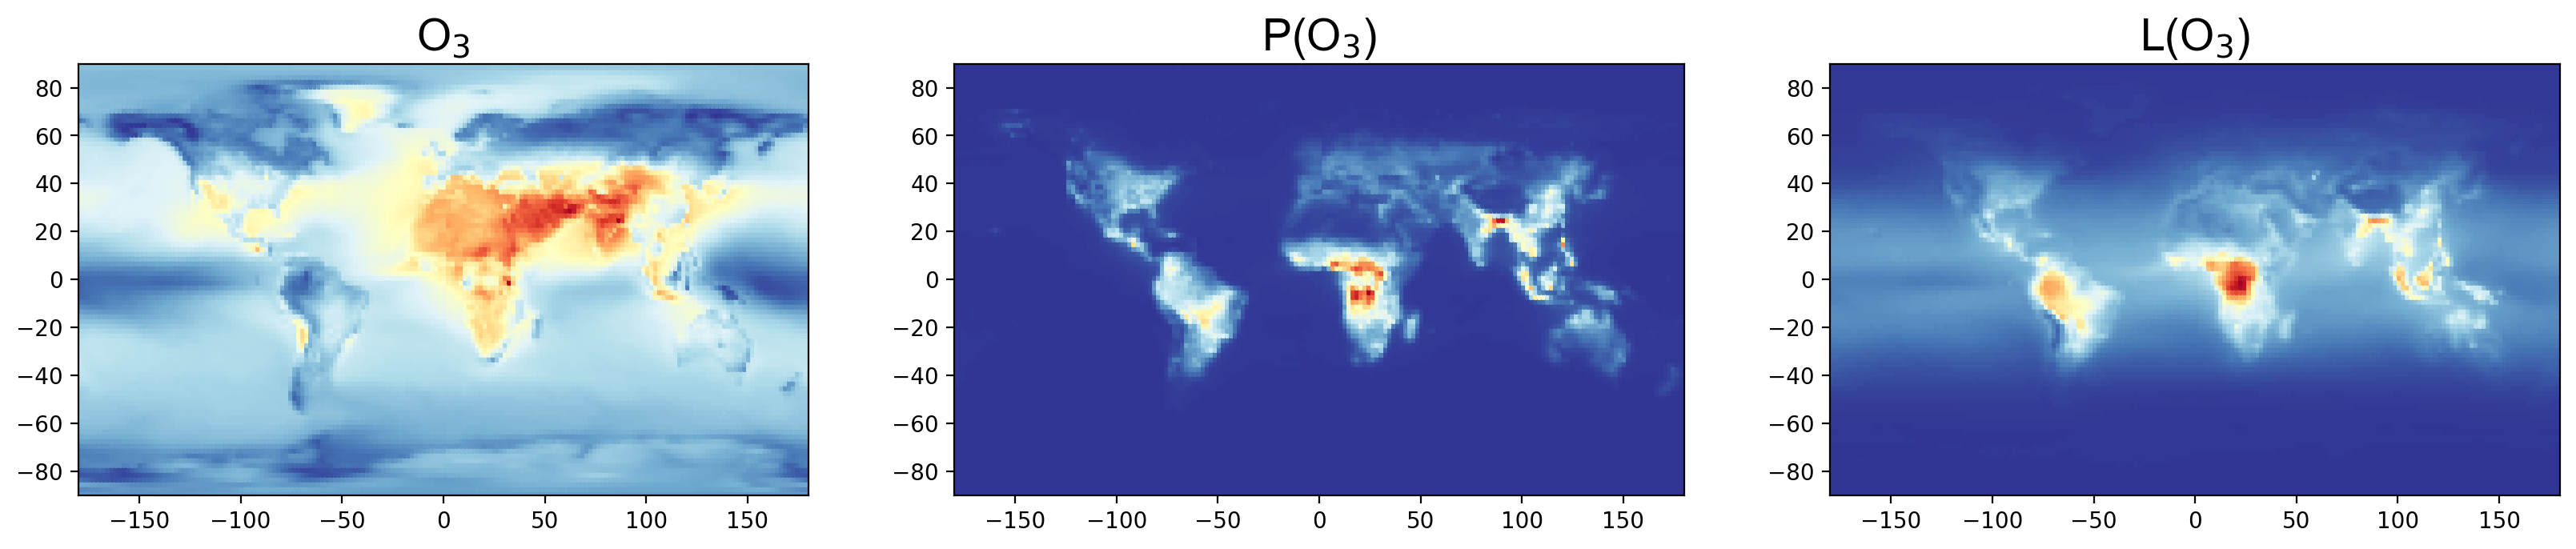

In [31]:
dataset_map = dataset_adj.groupby('loc').mean()
temp = dataset_map

plt.figure(num=None, figsize=(20, 3.5), dpi=200, facecolor='w', edgecolor='k')
cm = plt.cm.get_cmap('RdYlBu_r')
x = temp['longitude']
y = temp['latitude']

plt.subplot(1,3,1)
plt.title('O${_3}$', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['o3'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,3,2)
plt.title('P(O${_3}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['o3prod'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,3,3)
plt.title('L(O${_3}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['o3loss'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

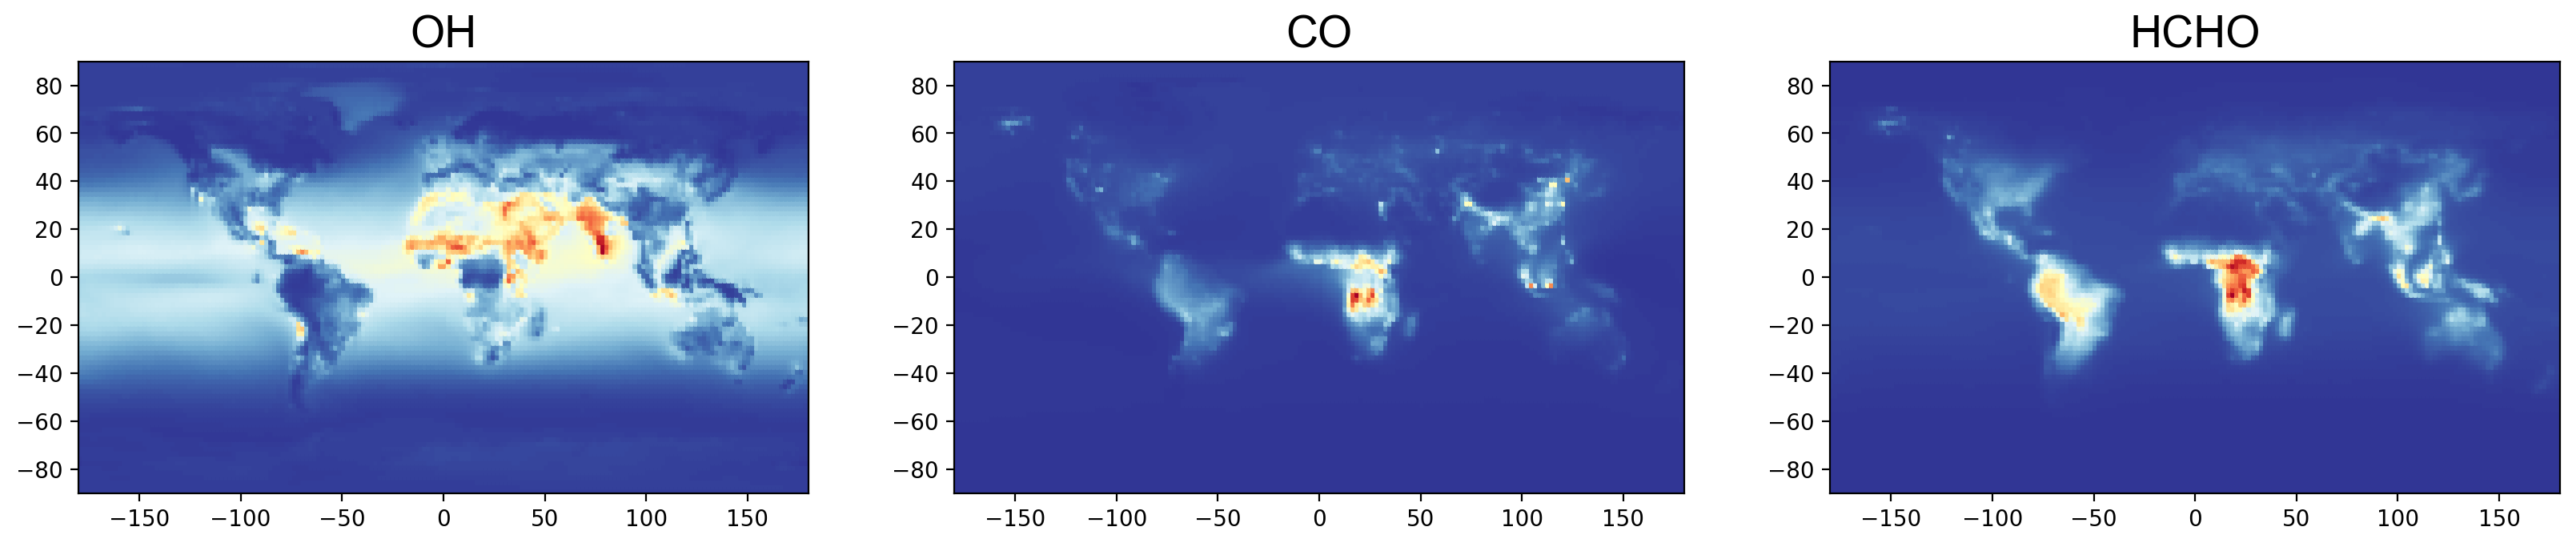

In [32]:
plt.figure(num=None, figsize=(20, 3.5), dpi=200, facecolor='w', edgecolor='k')
cm = plt.cm.get_cmap('RdYlBu_r')
x = temp['longitude']
y = temp['latitude']

plt.subplot(1,3,1)
plt.title('OH', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['oh'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,3,2)
plt.title('CO', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['co'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,3,3)
plt.title('HCHO', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['hcho'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

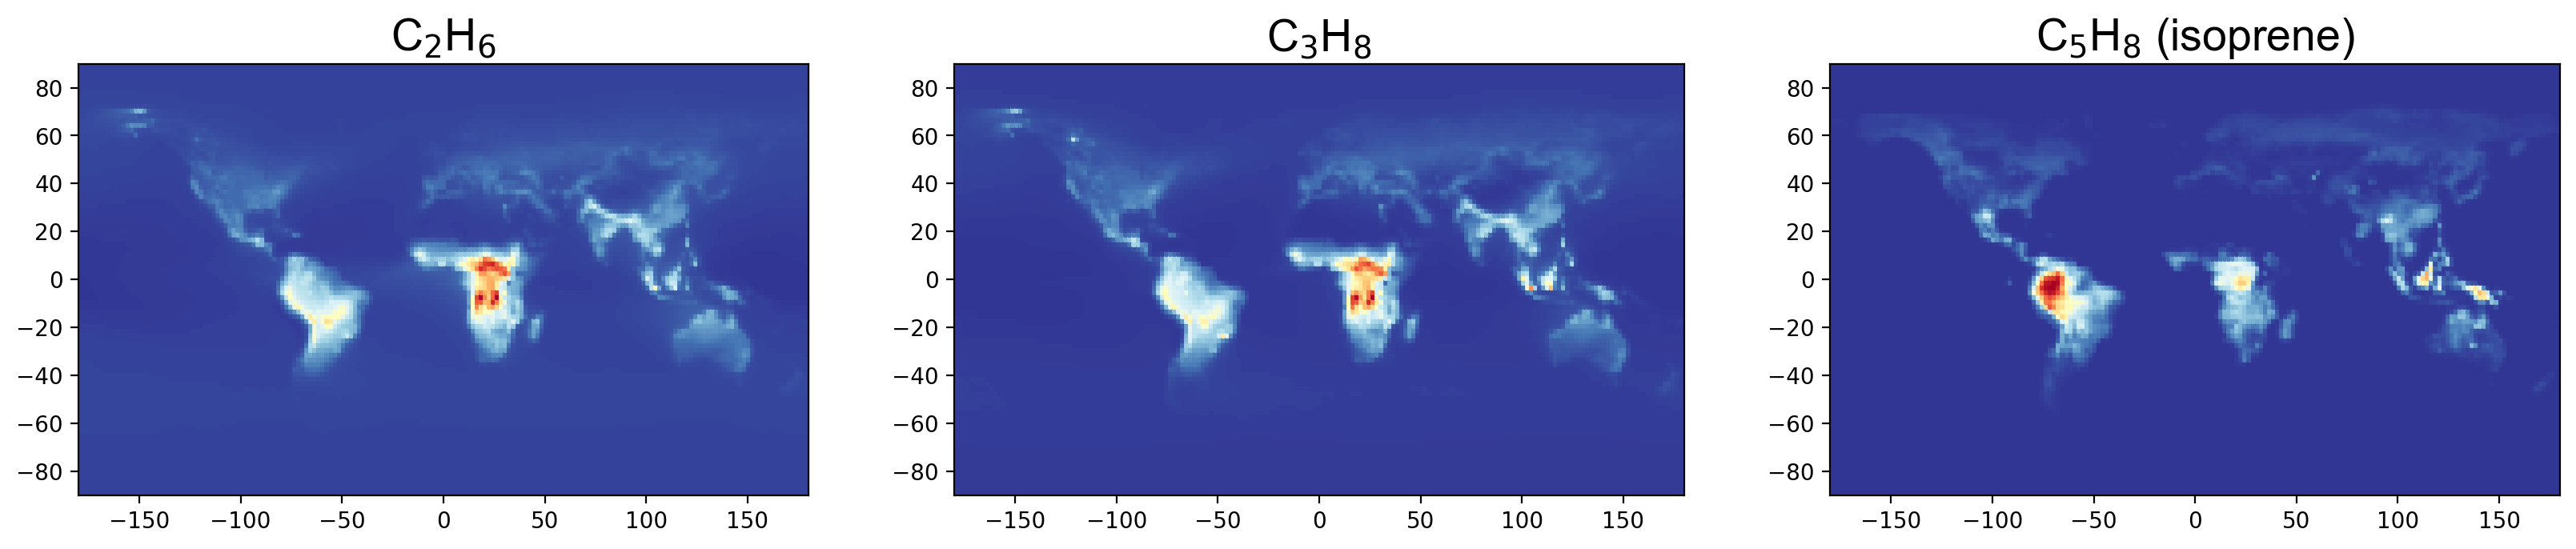

In [33]:
dataset_map = dataset_adj.groupby('loc').mean()
temp = dataset_map

plt.figure(num=None, figsize=(20, 3.5), dpi=200, facecolor='w', edgecolor='k')
cm = plt.cm.get_cmap('RdYlBu_r')
x = temp['longitude']
y = temp['latitude']

plt.subplot(1,3,1)
plt.title('C${_2}$H${_6}$', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['c2h6'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,3,2)
plt.title('C${_3}$H${_8}$', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['c3h8'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,3,3)
plt.title('C${_5}$H${_8}$ (isoprene)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['isop'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

#### Start steady-state iteration for radical approximation

In [34]:
dataset = pd.read_csv('/Users/csuen/Desktop/Sun-NG-24/radicals/UKESM1-0-LL_2100_ssp126(ver240112).csv')

In [35]:
dataset['n2_mole'] = dataset['ps']/8.314/dataset['tas']*6.022*10**23*10**(-6)*0.7808
dataset['o2_mole'] = dataset['ps']/8.314/dataset['tas']*6.022*10**23*10**(-6)*0.2095
dataset['h2o_mole'] = dataset['h2o']/18*6.022*10**23/(8.314*dataset['tas']/dataset['ps']/28.96*10**6)
dataset['o3_mole']   = dataset['o3']  *1.01325*10**5/dataset['tas']*7.243*10**7*10**9
dataset['no2_mole']  = dataset['no2'] *1.01325*10**5/dataset['tas']*7.243*10**7*10**9
dataset['no_mole']   = dataset['no']  *1.01325*10**5/dataset['tas']*7.243*10**7*10**9
dataset['oh_mole']   = dataset['oh']  *1.01325*10**5/dataset['tas']*7.243*10**7*10**9
dataset['co_mole']   = dataset['co']  *1.01325*10**5/dataset['tas']*7.243*10**7*10**9
dataset['hcho_mole'] = dataset['hcho']*1.01325*10**5/dataset['tas']*7.243*10**7*10**9
dataset['c2h6_mole'] = dataset['c2h6']*1.01325*10**5/dataset['tas']*7.243*10**7*10**9
dataset['c3h8_mole'] = dataset['c3h8']*1.01325*10**5/dataset['tas']*7.243*10**7*10**9
dataset['isop_mole'] = dataset['isop']*1.01325*10**5/dataset['tas']*7.243*10**7*10**9

In [36]:
dataset['k1'] = 2.15*10**(-11)*np.exp(110/dataset['tas'])
dataset['k2'] = 3.30*10**(-11)*np.exp(55/dataset['tas'])
dataset['k3'] = 1.63*10**(-10)*np.exp(60/dataset['tas'])
dataset['k4'] = 4.30*10**(-32)*(dataset['tas']/300)**(-1.2)*dataset['n2_mole']
dataset['k5'] = 1.44*10**(-13)

dataset['k6'] = 5.40*10**(-12)*np.exp(135/dataset['tas'])
dataset['k7'] = 1.70*10**(-12)*np.exp(-940/dataset['tas'])
dataset['k8'] = 2.45*10**(-12)*np.exp(-600/dataset['tas'])
dataset['k9'] = 4.01*10**(-12)*np.exp(190/dataset['tas'])
dataset['k9a'] = 2.12*10**(-12)*np.exp(190/dataset['tas'])
dataset['k9b'] = 1.89*10**(-12)*np.exp(190/dataset['tas'])

dataset['k10'] = 3.30*10**(-12)*np.exp(270/dataset['tas'])
dataset['k11'] = 2.03*10**(-16)*(dataset['tas']/300)**4.57*np.exp(693/dataset['tas'])
dataset['k12'] = 3.00*10**(-13)*np.exp(460/dataset['tas'])
dataset['k13'] = 4.80*10**(-11)*np.exp(250/dataset['tas'])

dataset['k14'] = 2.30*10**(-12)*np.exp(360/dataset['tas'])
dataset['k15'] = 3.80*10**(-13)*np.exp(780/dataset['tas'])
dataset['k15a'] = dataset['k15']/(1+498*np.exp(-1160/dataset['tas']))
dataset['k15b'] = dataset['k15']-dataset['k15a']
dataset['k16'] = 1.03*10**(-13)*np.exp(365/dataset['tas'])

dataset['k17'] = 6.90*10**(-12)*np.exp(-1000/dataset['tas'])
dataset['k18'] = 2.55*10**(-12)*np.exp(380/dataset['tas'])
dataset['k19'] = 6.40*10**(-13)*np.exp(710/dataset['tas'])
dataset['k20'] = 7.60*10**(-12)*np.exp(-585/dataset['tas'])
dataset['k21'] = 2.90*10**(-12)*np.exp(350/dataset['tas'])
dataset['k22'] = 1.51*10**(-13)*np.exp(1300/dataset['tas'])
dataset['k23'] = 2.70*10**(-11)*np.exp(390/dataset['tas'])
dataset['k24a'] = 2.43*10**(-12)*np.exp(360/dataset['tas'])
dataset['k24b'] = 1.12*10**(-13)*np.exp(360/dataset['tas'])
dataset['k24'] = 2.54*10**(-12)*np.exp(360/dataset['tas'])
dataset['k25'] = 2.05*10**(-13)*np.exp(1300/dataset['tas'])
dataset['k26'] = 2.00*10**(-12)
dataset['k27'] = 9.99*10**(-15)*np.exp(-1995/dataset['tas'])

#### Calculate the radical concentration of [O(${^1}$D)] via steady-state approximation

In [37]:
dataset['o1d_mole'] = dataset['photo1d']*dataset['o3_mole']/(dataset['k1']*dataset['n2_mole'] + dataset['k2']*dataset['o2_mole'] + dataset['k3']*dataset['h2o_mole'])

#### Set initial level of HO${_2}$ radical for iteration 

In [38]:
dataset['lossco_mole'] = dataset['lossco']*6.022*10**23*10**(-6)

dataset['A_0'] = 2*dataset['k12']
dataset['B_0'] = dataset['k10']*dataset['no_mole'] + dataset['k11']*dataset['o3_mole'] + dataset['k13']*dataset['oh_mole']
dataset['C_0'] = -(dataset['k6']*dataset['oh_mole']*dataset['hcho_mole'] + dataset['k7']*dataset['oh_mole']*dataset['o3_mole'] + dataset['lossco_mole'])

dataset['ho2_0'] = (-dataset['B_0']+(dataset['B_0']*dataset['B_0']-4*dataset['A_0']*dataset['C_0'])**(0.5))/(2*dataset['A_0'])

#### Set initial level of CH${_3}$O${_2}$ radical for iteration 

In [39]:
dataset['lossch4_mole'] = dataset['lossch4']*6.022*10**23*10**(-6)

dataset['D_0'] = 2*dataset['k16']
dataset['E_0'] = dataset['k14']*dataset['no_mole'] + dataset['k15']*dataset['ho2_0']
dataset['F_0'] = -(dataset['lossch4_mole'])

dataset['ch3o2_0'] = (-dataset['E_0']+(dataset['E_0']*dataset['E_0']-4*dataset['D_0']*dataset['F_0'])**(0.5))/(2*dataset['D_0'])

#### Set initial level of CH${_3}$O${_2}$H radical for iteration 

In [40]:
dataset['ch3ooh_0'] = dataset['k15b']*dataset['ho2_0']*dataset['ch3o2_0']/(dataset['k9']*dataset['oh_mole'])

### Now start iteration

In [41]:
dataset['A_1'] = 2*dataset['k12']
dataset['B_1'] = dataset['k10']*dataset['no_mole'] + dataset['k11']*dataset['o3_mole'] + dataset['k13']*dataset['oh_mole'] + dataset['k15']*dataset['ch3o2_0']
dataset['C_1'] = -(dataset['k14']*dataset['no_mole']*dataset['ch3o2_0'] + dataset['k6']*dataset['oh_mole']*dataset['hcho_mole'] + dataset['k7']*dataset['oh_mole']*dataset['o3_mole'] + dataset['lossco_mole']) 

dataset['ho2_1'] = (-dataset['B_1']+(dataset['B_1']*dataset['B_1']-4*dataset['A_1']*dataset['C_1'])**(0.5))/(2*dataset['A_1'])

dataset['D_1'] = 2*dataset['k16']
dataset['E_1'] = dataset['k14']*dataset['no_mole'] + dataset['k15']*dataset['ho2_1']
dataset['F_1'] = -(dataset['lossch4_mole'] + dataset['k9a']*dataset['ch3ooh_0']*dataset['oh_mole']) 

dataset['ch3o2_1'] = (-dataset['E_1']+(dataset['E_1']*dataset['E_1']-4*dataset['D_1']*dataset['F_1'])**(0.5))/(2*dataset['D_1'])

dataset['ch3ooh_1'] = dataset['k15b']*dataset['ho2_1']*dataset['ch3o2_1']/(dataset['k9']*dataset['oh_mole'])

In [42]:
dataset['A_2'] = 2*dataset['k12']
dataset['B_2'] = dataset['k10']*dataset['no_mole'] + dataset['k11']*dataset['o3_mole'] + dataset['k13']*dataset['oh_mole'] + dataset['k15']*dataset['ch3o2_1']
dataset['C_2'] = -(dataset['k14']*dataset['no_mole']*dataset['ch3o2_1'] + dataset['k6']*dataset['oh_mole']*dataset['hcho_mole'] + dataset['k7']*dataset['oh_mole']*dataset['o3_mole'] + dataset['lossco_mole']) 

dataset['ho2_2'] = (-dataset['B_2']+(dataset['B_2']*dataset['B_2']-4*dataset['A_2']*dataset['C_2'])**(0.5))/(2*dataset['A_2'])

dataset['D_2'] = 2*dataset['k16']
dataset['E_2'] = dataset['k14']*dataset['no_mole'] + dataset['k15']*dataset['ho2_2']
dataset['F_2'] = -(dataset['lossch4_mole'] + dataset['k9a']*dataset['ch3ooh_1']*dataset['oh_mole']) 

dataset['ch3o2_2'] = (-dataset['E_2']+(dataset['E_2']*dataset['E_2']-4*dataset['D_2']*dataset['F_2'])**(0.5))/(2*dataset['D_2'])

dataset['ch3ooh_2'] = dataset['k15b']*dataset['ho2_2']*dataset['ch3o2_2']/(dataset['k9']*dataset['oh_mole'])

In [43]:
dataset['A_3'] = 2*dataset['k12']
dataset['B_3'] = dataset['k10']*dataset['no_mole'] + dataset['k11']*dataset['o3_mole'] + dataset['k13']*dataset['oh_mole'] + dataset['k15']*dataset['ch3o2_2']
dataset['C_3'] = -(dataset['k14']*dataset['no_mole']*dataset['ch3o2_2'] + dataset['k6']*dataset['oh_mole']*dataset['hcho_mole'] + dataset['k7']*dataset['oh_mole']*dataset['o3_mole'] + dataset['lossco_mole']) 

dataset['ho2_3'] = (-dataset['B_3']+(dataset['B_3']*dataset['B_3']-4*dataset['A_3']*dataset['C_3'])**(0.5))/(2*dataset['A_3'])

dataset['D_3'] = 2*dataset['k16']
dataset['E_3'] = dataset['k14']*dataset['no_mole'] + dataset['k15']*dataset['ho2_3']
dataset['F_3'] = -(dataset['lossch4_mole'] + dataset['k9a']*dataset['ch3ooh_2']*dataset['oh_mole']) 

dataset['ch3o2_3'] = (-dataset['E_3']+(dataset['E_3']*dataset['E_3']-4*dataset['D_3']*dataset['F_3'])**(0.5))/(2*dataset['D_3'])

dataset['ch3ooh_3'] = dataset['k15b']*dataset['ho2_3']*dataset['ch3o2_3']/(dataset['k9']*dataset['oh_mole'])

In [44]:
dataset['A_4'] = 2*dataset['k12']
dataset['B_4'] = dataset['k10']*dataset['no_mole'] + dataset['k11']*dataset['o3_mole'] + dataset['k13']*dataset['oh_mole'] + dataset['k15']*dataset['ch3o2_3']
dataset['C_4'] = -(dataset['k14']*dataset['no_mole']*dataset['ch3o2_3'] + dataset['k6']*dataset['oh_mole']*dataset['hcho_mole'] + dataset['k7']*dataset['oh_mole']*dataset['o3_mole'] + dataset['lossco_mole']) 

dataset['ho2_4'] = (-dataset['B_4']+(dataset['B_4']*dataset['B_4']-4*dataset['A_4']*dataset['C_4'])**(0.5))/(2*dataset['A_4'])

dataset['D_4'] = 2*dataset['k16']
dataset['E_4'] = dataset['k14']*dataset['no_mole'] + dataset['k15']*dataset['ho2_4']
dataset['F_4'] = -(dataset['lossch4_mole'] + dataset['k9a']*dataset['ch3ooh_3']*dataset['oh_mole']) 

dataset['ch3o2_4'] = (-dataset['E_4']+(dataset['E_4']*dataset['E_4']-4*dataset['D_4']*dataset['F_4'])**(0.5))/(2*dataset['D_4'])

dataset['ch3ooh_4'] = dataset['k15b']*dataset['ho2_4']*dataset['ch3o2_4']/(dataset['k9']*dataset['oh_mole'])

In [45]:
dataset['A_5'] = 2*dataset['k12']
dataset['B_5'] = dataset['k10']*dataset['no_mole'] + dataset['k11']*dataset['o3_mole'] + dataset['k13']*dataset['oh_mole'] + dataset['k15']*dataset['ch3o2_4']
dataset['C_5'] = -(dataset['k14']*dataset['no_mole']*dataset['ch3o2_4'] + dataset['k6']*dataset['oh_mole']*dataset['hcho_mole'] + dataset['k7']*dataset['oh_mole']*dataset['o3_mole'] + dataset['lossco_mole']) 

dataset['ho2_5'] = (-dataset['B_5']+(dataset['B_5']*dataset['B_5']-4*dataset['A_5']*dataset['C_5'])**(0.5))/(2*dataset['A_5'])

dataset['D_5'] = 2*dataset['k16']
dataset['E_5'] = dataset['k14']*dataset['no_mole'] + dataset['k15']*dataset['ho2_5']
dataset['F_5'] = -(dataset['lossch4_mole'] + dataset['k9a']*dataset['ch3ooh_4']*dataset['oh_mole']) 

dataset['ch3o2_5'] = (-dataset['E_5']+(dataset['E_5']*dataset['E_5']-4*dataset['D_5']*dataset['F_5'])**(0.5))/(2*dataset['D_5'])

dataset['ch3ooh_5'] = dataset['k15b']*dataset['ho2_5']*dataset['ch3o2_5']/(dataset['k9']*dataset['oh_mole'])

In [46]:
dataset['A_6'] = 2*dataset['k12']
dataset['B_6'] = dataset['k10']*dataset['no_mole'] + dataset['k11']*dataset['o3_mole'] + dataset['k13']*dataset['oh_mole'] + dataset['k15']*dataset['ch3o2_5']
dataset['C_6'] = -(dataset['k14']*dataset['no_mole']*dataset['ch3o2_5'] + dataset['k6']*dataset['oh_mole']*dataset['hcho_mole'] + dataset['k7']*dataset['oh_mole']*dataset['o3_mole'] + dataset['lossco_mole']) 

dataset['ho2_6'] = (-dataset['B_6']+(dataset['B_6']*dataset['B_6']-4*dataset['A_6']*dataset['C_6'])**(0.5))/(2*dataset['A_6'])

dataset['D_6'] = 2*dataset['k16']
dataset['E_6'] = dataset['k14']*dataset['no_mole'] + dataset['k15']*dataset['ho2_6']
dataset['F_6'] = -(dataset['lossch4_mole'] + dataset['k9a']*dataset['ch3ooh_5']*dataset['oh_mole']) 

dataset['ch3o2_6'] = (-dataset['E_6']+(dataset['E_6']*dataset['E_6']-4*dataset['D_6']*dataset['F_6'])**(0.5))/(2*dataset['D_6'])

dataset['ch3ooh_6'] = dataset['k15b']*dataset['ho2_6']*dataset['ch3o2_6']/(dataset['k9']*dataset['oh_mole'])

In [47]:
dataset['A_7'] = 2*dataset['k12']
dataset['B_7'] = dataset['k10']*dataset['no_mole'] + dataset['k11']*dataset['o3_mole'] + dataset['k13']*dataset['oh_mole'] + dataset['k15']*dataset['ch3o2_6']
dataset['C_7'] = -(dataset['k14']*dataset['no_mole']*dataset['ch3o2_6'] + dataset['k6']*dataset['oh_mole']*dataset['hcho_mole'] + dataset['k7']*dataset['oh_mole']*dataset['o3_mole'] + dataset['lossco_mole']) 

dataset['ho2_7'] = (-dataset['B_7']+(dataset['B_7']*dataset['B_7']-4*dataset['A_7']*dataset['C_7'])**(0.5))/(2*dataset['A_7'])

dataset['D_7'] = 2*dataset['k16']
dataset['E_7'] = dataset['k14']*dataset['no_mole'] + dataset['k15']*dataset['ho2_7']
dataset['F_7'] = -(dataset['lossch4_mole'] + dataset['k9a']*dataset['ch3ooh_6']*dataset['oh_mole']) 

dataset['ch3o2_7'] = (-dataset['E_7']+(dataset['E_7']*dataset['E_7']-4*dataset['D_7']*dataset['F_7'])**(0.5))/(2*dataset['D_7'])

dataset['ch3ooh_7'] = dataset['k15b']*dataset['ho2_7']*dataset['ch3o2_7']/(dataset['k9']*dataset['oh_mole'])

In [48]:
dataset['A_8'] = 2*dataset['k12']
dataset['B_8'] = dataset['k10']*dataset['no_mole'] + dataset['k11']*dataset['o3_mole'] + dataset['k13']*dataset['oh_mole'] + dataset['k15']*dataset['ch3o2_7']
dataset['C_8'] = -(dataset['k14']*dataset['no_mole']*dataset['ch3o2_7'] + dataset['k6']*dataset['oh_mole']*dataset['hcho_mole'] + dataset['k7']*dataset['oh_mole']*dataset['o3_mole'] + dataset['lossco_mole']) 

dataset['ho2_8'] = (-dataset['B_8']+(dataset['B_8']*dataset['B_8']-4*dataset['A_8']*dataset['C_8'])**(0.5))/(2*dataset['A_8'])

dataset['D_8'] = 2*dataset['k16']
dataset['E_8'] = dataset['k14']*dataset['no_mole'] + dataset['k15']*dataset['ho2_8']
dataset['F_8'] = -(dataset['lossch4_mole'] + dataset['k9a']*dataset['ch3ooh_7']*dataset['oh_mole']) 

dataset['ch3o2_8'] = (-dataset['E_8']+(dataset['E_8']*dataset['E_8']-4*dataset['D_8']*dataset['F_8'])**(0.5))/(2*dataset['D_8'])

dataset['ch3ooh_8'] = dataset['k15b']*dataset['ho2_8']*dataset['ch3o2_8']/(dataset['k9']*dataset['oh_mole'])

In [49]:
dataset['A_9'] = 2*dataset['k12']
dataset['B_9'] = dataset['k10']*dataset['no_mole'] + dataset['k11']*dataset['o3_mole'] + dataset['k13']*dataset['oh_mole'] + dataset['k15']*dataset['ch3o2_8']
dataset['C_9'] = -(dataset['k14']*dataset['no_mole']*dataset['ch3o2_8'] + dataset['k6']*dataset['oh_mole']*dataset['hcho_mole'] + dataset['k7']*dataset['oh_mole']*dataset['o3_mole'] + dataset['lossco_mole']) 

dataset['ho2_9'] = (-dataset['B_9']+(dataset['B_9']*dataset['B_9']-4*dataset['A_9']*dataset['C_9'])**(0.5))/(2*dataset['A_9'])

dataset['D_9'] = 2*dataset['k16']
dataset['E_9'] = dataset['k14']*dataset['no_mole'] + dataset['k15']*dataset['ho2_9']
dataset['F_9'] = -(dataset['lossch4_mole'] + dataset['k9a']*dataset['ch3ooh_8']*dataset['oh_mole']) 

dataset['ch3o2_9'] = (-dataset['E_9']+(dataset['E_9']*dataset['E_9']-4*dataset['D_9']*dataset['F_9'])**(0.5))/(2*dataset['D_9'])

dataset['ch3ooh_9'] = dataset['k15b']*dataset['ho2_9']*dataset['ch3o2_9']/(dataset['k9']*dataset['oh_mole'])

In [50]:
dataset['A_10'] = 2*dataset['k12']
dataset['B_10'] = dataset['k10']*dataset['no_mole'] + dataset['k11']*dataset['o3_mole'] + dataset['k13']*dataset['oh_mole'] + dataset['k15']*dataset['ch3o2_9']
dataset['C_10'] = -(dataset['k14']*dataset['no_mole']*dataset['ch3o2_9'] + dataset['k6']*dataset['oh_mole']*dataset['hcho_mole'] + dataset['k7']*dataset['oh_mole']*dataset['o3_mole'] + dataset['lossco_mole']) 

dataset['ho2_10'] = (-dataset['B_10']+(dataset['B_10']*dataset['B_10']-4*dataset['A_10']*dataset['C_10'])**(0.5))/(2*dataset['A_10'])

dataset['D_10'] = 2*dataset['k16']
dataset['E_10'] = dataset['k14']*dataset['no_mole'] + dataset['k15']*dataset['ho2_10']
dataset['F_10'] = -(dataset['lossch4_mole'] + dataset['k9a']*dataset['ch3ooh_9']*dataset['oh_mole']) 

dataset['ch3o2_10'] = (-dataset['E_10']+(dataset['E_10']*dataset['E_10']-4*dataset['D_10']*dataset['F_10'])**(0.5))/(2*dataset['D_10'])

dataset['ch3ooh_10'] = dataset['k15b']*dataset['ho2_10']*dataset['ch3o2_10']/(dataset['k9']*dataset['oh_mole'])

In [51]:
dataset['A_11'] = 2*dataset['k12']
dataset['B_11'] = dataset['k10']*dataset['no_mole'] + dataset['k11']*dataset['o3_mole'] + dataset['k13']*dataset['oh_mole'] + dataset['k15']*dataset['ch3o2_10']
dataset['C_11'] = -(dataset['k14']*dataset['no_mole']*dataset['ch3o2_10'] + dataset['k6']*dataset['oh_mole']*dataset['hcho_mole'] + dataset['k7']*dataset['oh_mole']*dataset['o3_mole'] + dataset['lossco_mole']) 

dataset['ho2_11'] = (-dataset['B_11']+(dataset['B_11']*dataset['B_11']-4*dataset['A_11']*dataset['C_11'])**(0.5))/(2*dataset['A_11'])

dataset['D_11'] = 2*dataset['k16']
dataset['E_11'] = dataset['k14']*dataset['no_mole'] + dataset['k15']*dataset['ho2_11']
dataset['F_11'] = -(dataset['lossch4_mole'] + dataset['k9a']*dataset['ch3ooh_10']*dataset['oh_mole']) 

dataset['ch3o2_11'] = (-dataset['E_11']+(dataset['E_11']*dataset['E_11']-4*dataset['D_11']*dataset['F_11'])**(0.5))/(2*dataset['D_11'])

dataset['ch3ooh_11'] = dataset['k15b']*dataset['ho2_11']*dataset['ch3o2_11']/(dataset['k9']*dataset['oh_mole'])

In [52]:
dataset['A_12'] = 2*dataset['k12']
dataset['B_12'] = dataset['k10']*dataset['no_mole'] + dataset['k11']*dataset['o3_mole'] + dataset['k13']*dataset['oh_mole'] + dataset['k15']*dataset['ch3o2_11']
dataset['C_12'] = -(dataset['k14']*dataset['no_mole']*dataset['ch3o2_11'] + dataset['k6']*dataset['oh_mole']*dataset['hcho_mole'] + dataset['k7']*dataset['oh_mole']*dataset['o3_mole'] + dataset['lossco_mole']) 

dataset['ho2_12'] = (-dataset['B_12']+(dataset['B_12']*dataset['B_12']-4*dataset['A_12']*dataset['C_12'])**(0.5))/(2*dataset['A_12'])

dataset['D_12'] = 2*dataset['k16']
dataset['E_12'] = dataset['k14']*dataset['no_mole'] + dataset['k15']*dataset['ho2_12']
dataset['F_12'] = -(dataset['lossch4_mole'] + dataset['k9a']*dataset['ch3ooh_11']*dataset['oh_mole']) 

dataset['ch3o2_12'] = (-dataset['E_12']+(dataset['E_12']*dataset['E_12']-4*dataset['D_12']*dataset['F_12'])**(0.5))/(2*dataset['D_12'])

dataset['ch3ooh_12'] = dataset['k15b']*dataset['ho2_12']*dataset['ch3o2_12']/(dataset['k9']*dataset['oh_mole'])

In [53]:
dataset['A_13'] = 2*dataset['k12']
dataset['B_13'] = dataset['k10']*dataset['no_mole'] + dataset['k11']*dataset['o3_mole'] + dataset['k13']*dataset['oh_mole'] + dataset['k15']*dataset['ch3o2_12']
dataset['C_13'] = -(dataset['k14']*dataset['no_mole']*dataset['ch3o2_12'] + dataset['k6']*dataset['oh_mole']*dataset['hcho_mole'] + dataset['k7']*dataset['oh_mole']*dataset['o3_mole'] + dataset['lossco_mole']) 

dataset['ho2_13'] = (-dataset['B_13']+(dataset['B_13']*dataset['B_13']-4*dataset['A_13']*dataset['C_13'])**(0.5))/(2*dataset['A_13'])

dataset['D_13'] = 2*dataset['k16']
dataset['E_13'] = dataset['k14']*dataset['no_mole'] + dataset['k15']*dataset['ho2_13']
dataset['F_13'] = -(dataset['lossch4_mole'] + dataset['k9a']*dataset['ch3ooh_12']*dataset['oh_mole']) 

dataset['ch3o2_13'] = (-dataset['E_13']+(dataset['E_13']*dataset['E_13']-4*dataset['D_13']*dataset['F_13'])**(0.5))/(2*dataset['D_13'])

dataset['ch3ooh_13'] = dataset['k15b']*dataset['ho2_13']*dataset['ch3o2_13']/(dataset['k9']*dataset['oh_mole'])

In [54]:
dataset['A_14'] = 2*dataset['k12']
dataset['B_14'] = dataset['k10']*dataset['no_mole'] + dataset['k11']*dataset['o3_mole'] + dataset['k13']*dataset['oh_mole'] + dataset['k15']*dataset['ch3o2_13']
dataset['C_14'] = -(dataset['k14']*dataset['no_mole']*dataset['ch3o2_13'] + dataset['k6']*dataset['oh_mole']*dataset['hcho_mole'] + dataset['k7']*dataset['oh_mole']*dataset['o3_mole'] + dataset['lossco_mole']) 

dataset['ho2_14'] = (-dataset['B_14']+(dataset['B_14']*dataset['B_14']-4*dataset['A_14']*dataset['C_14'])**(0.5))/(2*dataset['A_14'])

dataset['D_14'] = 2*dataset['k16']
dataset['E_14'] = dataset['k14']*dataset['no_mole'] + dataset['k15']*dataset['ho2_14']
dataset['F_14'] = -(dataset['lossch4_mole'] + dataset['k9a']*dataset['ch3ooh_13']*dataset['oh_mole']) 

dataset['ch3o2_14'] = (-dataset['E_14']+(dataset['E_14']*dataset['E_14']-4*dataset['D_14']*dataset['F_14'])**(0.5))/(2*dataset['D_14'])

dataset['ch3ooh_14'] = dataset['k15b']*dataset['ho2_14']*dataset['ch3o2_14']/(dataset['k9']*dataset['oh_mole'])

In [55]:
dataset['A_15'] = 2*dataset['k12']
dataset['B_15'] = dataset['k10']*dataset['no_mole'] + dataset['k11']*dataset['o3_mole'] + dataset['k13']*dataset['oh_mole'] + dataset['k15']*dataset['ch3o2_14']
dataset['C_15'] = -(dataset['k14']*dataset['no_mole']*dataset['ch3o2_14'] + dataset['k6']*dataset['oh_mole']*dataset['hcho_mole'] + dataset['k7']*dataset['oh_mole']*dataset['o3_mole'] + dataset['lossco_mole']) 

dataset['ho2_15'] = (-dataset['B_15']+(dataset['B_15']*dataset['B_15']-4*dataset['A_15']*dataset['C_15'])**(0.5))/(2*dataset['A_15'])

dataset['D_15'] = 2*dataset['k16']
dataset['E_15'] = dataset['k14']*dataset['no_mole'] + dataset['k15']*dataset['ho2_15']
dataset['F_15'] = -(dataset['lossch4_mole'] + dataset['k9a']*dataset['ch3ooh_14']*dataset['oh_mole']) 

dataset['ch3o2_15'] = (-dataset['E_15']+(dataset['E_15']*dataset['E_15']-4*dataset['D_15']*dataset['F_15'])**(0.5))/(2*dataset['D_15'])

dataset['ch3ooh_15'] = dataset['k15b']*dataset['ho2_15']*dataset['ch3o2_15']/(dataset['k9']*dataset['oh_mole'])

In [56]:
dataset['A_16'] = 2*dataset['k12']
dataset['B_16'] = dataset['k10']*dataset['no_mole'] + dataset['k11']*dataset['o3_mole'] + dataset['k13']*dataset['oh_mole'] + dataset['k15']*dataset['ch3o2_15']
dataset['C_16'] = -(dataset['k14']*dataset['no_mole']*dataset['ch3o2_15'] + dataset['k6']*dataset['oh_mole']*dataset['hcho_mole'] + dataset['k7']*dataset['oh_mole']*dataset['o3_mole'] + dataset['lossco_mole']) 

dataset['ho2_16'] = (-dataset['B_16']+(dataset['B_16']*dataset['B_16']-4*dataset['A_16']*dataset['C_16'])**(0.5))/(2*dataset['A_16'])

dataset['D_16'] = 2*dataset['k16']
dataset['E_16'] = dataset['k14']*dataset['no_mole'] + dataset['k15']*dataset['ho2_16']
dataset['F_16'] = -(dataset['lossch4_mole'] + dataset['k9a']*dataset['ch3ooh_15']*dataset['oh_mole']) 

dataset['ch3o2_16'] = (-dataset['E_16']+(dataset['E_16']*dataset['E_16']-4*dataset['D_16']*dataset['F_16'])**(0.5))/(2*dataset['D_16'])

dataset['ch3ooh_16'] = dataset['k15b']*dataset['ho2_16']*dataset['ch3o2_16']/(dataset['k9']*dataset['oh_mole'])

In [57]:
dataset['A_17'] = 2*dataset['k12']
dataset['B_17'] = dataset['k10']*dataset['no_mole'] + dataset['k11']*dataset['o3_mole'] + dataset['k13']*dataset['oh_mole'] + dataset['k15']*dataset['ch3o2_16']
dataset['C_17'] = -(dataset['k14']*dataset['no_mole']*dataset['ch3o2_16'] + dataset['k6']*dataset['oh_mole']*dataset['hcho_mole'] + dataset['k7']*dataset['oh_mole']*dataset['o3_mole'] + dataset['lossco_mole']) 

dataset['ho2_17'] = (-dataset['B_17']+(dataset['B_17']*dataset['B_17']-4*dataset['A_17']*dataset['C_17'])**(0.5))/(2*dataset['A_17'])

dataset['D_17'] = 2*dataset['k16']
dataset['E_17'] = dataset['k14']*dataset['no_mole'] + dataset['k15']*dataset['ho2_17']
dataset['F_17'] = -(dataset['lossch4_mole'] + dataset['k9a']*dataset['ch3ooh_16']*dataset['oh_mole']) 

dataset['ch3o2_17'] = (-dataset['E_17']+(dataset['E_17']*dataset['E_17']-4*dataset['D_17']*dataset['F_17'])**(0.5))/(2*dataset['D_17'])

dataset['ch3ooh_17'] = dataset['k15b']*dataset['ho2_17']*dataset['ch3o2_17']/(dataset['k9']*dataset['oh_mole'])

In [58]:
dataset['A_18'] = 2*dataset['k12']
dataset['B_18'] = dataset['k10']*dataset['no_mole'] + dataset['k11']*dataset['o3_mole'] + dataset['k13']*dataset['oh_mole'] + dataset['k15']*dataset['ch3o2_17']
dataset['C_18'] = -(dataset['k14']*dataset['no_mole']*dataset['ch3o2_17'] + dataset['k6']*dataset['oh_mole']*dataset['hcho_mole'] + dataset['k7']*dataset['oh_mole']*dataset['o3_mole'] + dataset['lossco_mole']) 

dataset['ho2_18'] = (-dataset['B_18']+(dataset['B_18']*dataset['B_18']-4*dataset['A_18']*dataset['C_18'])**(0.5))/(2*dataset['A_18'])

dataset['D_18'] = 2*dataset['k16']
dataset['E_18'] = dataset['k14']*dataset['no_mole'] + dataset['k15']*dataset['ho2_18']
dataset['F_18'] = -(dataset['lossch4_mole'] + dataset['k9a']*dataset['ch3ooh_17']*dataset['oh_mole']) 

dataset['ch3o2_18'] = (-dataset['E_18']+(dataset['E_18']*dataset['E_18']-4*dataset['D_18']*dataset['F_18'])**(0.5))/(2*dataset['D_18'])

dataset['ch3ooh_18'] = dataset['k15b']*dataset['ho2_18']*dataset['ch3o2_18']/(dataset['k9']*dataset['oh_mole'])

In [59]:
dataset['A_19'] = 2*dataset['k12']
dataset['B_19'] = dataset['k10']*dataset['no_mole'] + dataset['k11']*dataset['o3_mole'] + dataset['k13']*dataset['oh_mole'] + dataset['k15']*dataset['ch3o2_18']
dataset['C_19'] = -(dataset['k14']*dataset['no_mole']*dataset['ch3o2_18'] + dataset['k6']*dataset['oh_mole']*dataset['hcho_mole'] + dataset['k7']*dataset['oh_mole']*dataset['o3_mole'] + dataset['lossco_mole']) 

dataset['ho2_19'] = (-dataset['B_19']+(dataset['B_19']*dataset['B_19']-4*dataset['A_19']*dataset['C_19'])**(0.5))/(2*dataset['A_19'])

dataset['D_19'] = 2*dataset['k16']
dataset['E_19'] = dataset['k14']*dataset['no_mole'] + dataset['k15']*dataset['ho2_19']
dataset['F_19'] = -(dataset['lossch4_mole'] + dataset['k9a']*dataset['ch3ooh_18']*dataset['oh_mole']) 

dataset['ch3o2_19'] = (-dataset['E_19']+(dataset['E_19']*dataset['E_19']-4*dataset['D_19']*dataset['F_19'])**(0.5))/(2*dataset['D_19'])

dataset['ch3ooh_19'] = dataset['k15b']*dataset['ho2_19']*dataset['ch3o2_19']/(dataset['k9']*dataset['oh_mole'])

In [60]:
dataset['A_20'] = 2*dataset['k12']
dataset['B_20'] = dataset['k10']*dataset['no_mole'] + dataset['k11']*dataset['o3_mole'] + dataset['k13']*dataset['oh_mole'] + dataset['k15']*dataset['ch3o2_19']
dataset['C_20'] = -(dataset['k14']*dataset['no_mole']*dataset['ch3o2_19'] + dataset['k6']*dataset['oh_mole']*dataset['hcho_mole'] + dataset['k7']*dataset['oh_mole']*dataset['o3_mole'] + dataset['lossco_mole']) 

dataset['ho2_20'] = (-dataset['B_20']+(dataset['B_20']*dataset['B_20']-4*dataset['A_20']*dataset['C_20'])**(0.5))/(2*dataset['A_20'])

dataset['D_20'] = 2*dataset['k16']
dataset['E_20'] = dataset['k14']*dataset['no_mole'] + dataset['k15']*dataset['ho2_20']
dataset['F_20'] = -(dataset['lossch4_mole'] + dataset['k9a']*dataset['ch3ooh_19']*dataset['oh_mole']) 

dataset['ch3o2_20'] = (-dataset['E_20']+(dataset['E_20']*dataset['E_20']-4*dataset['D_20']*dataset['F_20'])**(0.5))/(2*dataset['D_20'])

dataset['ch3ooh_20'] = dataset['k15b']*dataset['ho2_20']*dataset['ch3o2_20']/(dataset['k9']*dataset['oh_mole'])

In [61]:
list(dataset)

['longitude',
 'latitude',
 't',
 'loc',
 'o3',
 'o3prod',
 'o3loss',
 'tas',
 'ps',
 'jno2',
 'photo1d',
 'lossch4',
 'lossco',
 'no2',
 'no',
 'oh',
 'h2o',
 'co',
 'hcho',
 'c2h6',
 'c3h8',
 'isop',
 'n2_mole',
 'o2_mole',
 'h2o_mole',
 'o3_mole',
 'no2_mole',
 'no_mole',
 'oh_mole',
 'co_mole',
 'hcho_mole',
 'c2h6_mole',
 'c3h8_mole',
 'isop_mole',
 'k1',
 'k2',
 'k3',
 'k4',
 'k5',
 'k6',
 'k7',
 'k8',
 'k9',
 'k9a',
 'k9b',
 'k10',
 'k11',
 'k12',
 'k13',
 'k14',
 'k15',
 'k15a',
 'k15b',
 'k16',
 'k17',
 'k18',
 'k19',
 'k20',
 'k21',
 'k22',
 'k23',
 'k24a',
 'k24b',
 'k24',
 'k25',
 'k26',
 'k27',
 'o1d_mole',
 'lossco_mole',
 'A_0',
 'B_0',
 'C_0',
 'ho2_0',
 'lossch4_mole',
 'D_0',
 'E_0',
 'F_0',
 'ch3o2_0',
 'ch3ooh_0',
 'A_1',
 'B_1',
 'C_1',
 'ho2_1',
 'D_1',
 'E_1',
 'F_1',
 'ch3o2_1',
 'ch3ooh_1',
 'A_2',
 'B_2',
 'C_2',
 'ho2_2',
 'D_2',
 'E_2',
 'F_2',
 'ch3o2_2',
 'ch3ooh_2',
 'A_3',
 'B_3',
 'C_3',
 'ho2_3',
 'D_3',
 'E_3',
 'F_3',
 'ch3o2_3',
 'ch3ooh_3',
 'A_4',

In [62]:
dataset_radicals = dataset[['longitude','latitude','t','loc','o3','o3prod','o3loss','tas','ps','jno2','photo1d','lossch4','lossco',
                            'no2','no','oh','h2o','co','hcho','c2h6','c3h8','isop',
                            'n2_mole','o2_mole','h2o_mole','o3_mole','no2_mole','no_mole','oh_mole',
                            'co_mole','hcho_mole','c2h6_mole','c3h8_mole','isop_mole',
                            'k1','k2','k3','k4','k5','k6','k7','k8','k9','k9a','k9b','k10','k11','k12','k13','k14','k15','k15a','k15b','k16',
                            'k17','k18','k19','k20','k21','k22','k23','k24a','k24b','k24','k25','k26','k27',
                            'o1d_mole','lossco_mole','lossch4_mole']]

In [63]:
dataset_radicals['ho2_mole'] = dataset['ho2_20']
dataset_radicals['ch3o2_mole'] = dataset['ch3o2_20']
dataset_radicals['ch3ooh_mole'] = dataset['ch3ooh_20']

In [64]:
dataset_radicals['o3prod_mole'] = dataset_radicals['o3prod']*6.022*10**23*10**(-6)
dataset_radicals['o3loss_mole'] = dataset_radicals['o3loss']*6.022*10**23*10**(-6)

In [65]:
dataset_radicals['etoo_mole'] = dataset_radicals['k17']*dataset_radicals['c2h6_mole']*dataset_radicals['oh_mole']/(dataset_radicals['k18']*dataset_radicals['no_mole']+dataset_radicals['k19']*dataset_radicals['ho2_mole'])
dataset_radicals['proo_mole'] = dataset_radicals['k20']*dataset_radicals['c3h8_mole']*dataset_radicals['oh_mole']/(dataset_radicals['k21']*dataset_radicals['no_mole']+dataset_radicals['k22']*dataset_radicals['ho2_mole'])

In [66]:
dataset_radicals['a'] = 2*dataset_radicals['k26']
dataset_radicals['b'] = dataset_radicals['k24']*dataset_radicals['no_mole'] + dataset_radicals['k25']*dataset_radicals['ho2_mole']
dataset_radicals['c'] = -2*dataset_radicals['k23']*dataset_radicals['isop_mole']*dataset_radicals['oh_mole']

dataset_radicals['delta'] = dataset_radicals['b']*dataset_radicals['b']-4*dataset_radicals['a']*dataset_radicals['c']

#dataset_radicals['iso2_mole'] = dataset_radicals['k23']*dataset_radicals['isop_mole']*dataset_radicals['oh_mole']/(dataset_radicals['k24']*dataset_radicals['no_mole']+dataset_radicals['k25']*dataset_radicals['ho2_mole'])
dataset_radicals['iso2_mole'] = (-dataset_radicals['b']+dataset_radicals['delta']**0.5)/(2*dataset_radicals['a'])

In [67]:
dataset_radicals.to_csv('/Users/csuen/Desktop/Sun-NG-24/radicals/UKESM1-0-LL_2100_ssp126(ver240112).csv', index=False)
dataset = pd.read_csv('/Users/csuen/Desktop/Sun-NG-24/radicals/UKESM1-0-LL_2100_ssp126(ver240112).csv')

In [68]:
dataset['prod_etoo_no'] = dataset['k18']*dataset['etoo_mole']*dataset['no_mole']
dataset['prod_proo_no'] = dataset['k21']*dataset['proo_mole']*dataset['no_mole']
dataset['prod_iso2_no'] = dataset['k24a']*dataset['iso2_mole']*dataset['no_mole']
dataset['loss_o3_isop'] = dataset['k27']*dataset['o3_mole']*dataset['isop_mole']

In [69]:
dataset['pt1'] = dataset['k10']*dataset['ho2_mole']*dataset['no_mole']
dataset['pt2'] = dataset['k14']*dataset['ch3o2_mole']*dataset['no_mole']
dataset['o3prod_mole_stacked'] = dataset['pt1']+dataset['pt2']+dataset['prod_etoo_no']+dataset['prod_proo_no']+dataset['prod_iso2_no']
dataset['pt3'] = dataset['o3prod_mole_stacked'] - dataset['pt1'] - dataset['pt2']

dataset['pt4'] = dataset['k3']*dataset['o1d_mole']*dataset['h2o_mole']
dataset['pt5'] = dataset['k7']*dataset['oh_mole']*dataset['o3_mole']
dataset['pt6'] = dataset['k11']*dataset['ho2_mole']*dataset['o3_mole']
dataset['o3loss_mole_stacked'] = dataset['pt4']+dataset['pt5']+dataset['pt6']+dataset['loss_o3_isop']
dataset['pt7'] = dataset['o3loss_mole_stacked'] - dataset['pt4'] - dataset['pt5'] - dataset['pt6']

In [70]:
dataset['pt1_prop'] = dataset['pt1']/dataset['o3prod_mole_stacked']
dataset['pt2_prop'] = dataset['pt2']/dataset['o3prod_mole_stacked']
dataset['pt3_prop'] = dataset['pt3']/dataset['o3prod_mole_stacked']

dataset['pt4_prop'] = dataset['pt4']/dataset['o3loss_mole_stacked']
dataset['pt5_prop'] = dataset['pt5']/dataset['o3loss_mole_stacked']
dataset['pt6_prop'] = dataset['pt6']/dataset['o3loss_mole_stacked']
dataset['pt7_prop'] = dataset['pt7']/dataset['o3loss_mole_stacked']

(-90.0, 90.0)

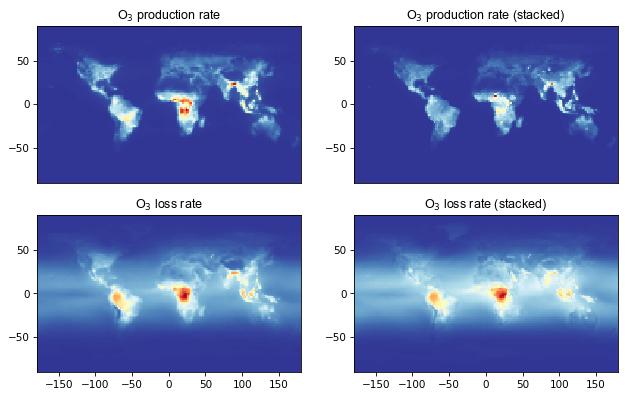

In [71]:
dataset_map = dataset.groupby('loc').mean()
temp = dataset_map

plt.figure(num=None, figsize=(10, 6), dpi=75, facecolor='w', edgecolor='k')
cm = plt.cm.get_cmap('RdYlBu_r')
x = temp['longitude']
y = temp['latitude']

plt.subplot(2,2,1)
plt.title('O${_3}$ production rate', fontsize = 12, fontname = "Arial", color = "black")
z = temp['o3prod_mole']
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.xticks([])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,2,2)
plt.title('O${_3}$ production rate (stacked)', fontsize = 12, fontname = "Arial", color = "black")
z = temp['o3prod_mole_stacked']
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.xticks([])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,2,3)
plt.title('O${_3}$ loss rate', fontsize = 12, fontname = "Arial", color = "black")
z = temp['o3loss_mole']
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,2,4)
plt.title('O${_3}$ loss rate (stacked)', fontsize = 12, fontname = "Arial", color = "black")
z = temp['o3loss_mole_stacked']
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

In [72]:
def Pearson_correlation(X,Y):
	if len(X)==len(Y):
		Sum_xy = sum((X-X.mean())*(Y-Y.mean()))
		Sum_x_squared = sum((X-X.mean())**2)
		Sum_y_squared = sum((Y-Y.mean())**2)	 
		corr = Sum_xy / np.sqrt(Sum_x_squared * Sum_y_squared)
	return corr

In [73]:
Pearson_correlation(dataset['o3prod_mole'], dataset['o3prod_mole_stacked'])

0.9123363962404374

In [74]:
Pearson_correlation(dataset['o3loss_mole'], dataset['o3loss_mole_stacked'])

0.9672982465893053

In [75]:
print(np.round(dataset['pt1_prop'].mean(),3))
print(np.round(dataset['pt2_prop'].mean(),3))
print(np.round(dataset['pt3_prop'].mean(),3))

0.368
0.428
0.204


In [76]:
print(np.round(dataset['pt4_prop'].mean(),3))
print(np.round(dataset['pt5_prop'].mean(),3))
print(np.round(dataset['pt6_prop'].mean(),3))
print(np.round(dataset['pt7_prop'].mean(),3))

0.471
0.091
0.366
0.071


In [77]:
land = pd.read_csv('/Users/csuen/Documents/GitHub/ozone-budget/global_grid_2x2_label_continent.csv')
dataset_land = dataset.merge(land, how='left', left_on=['longitude','latitude'], right_on=['longitude','latitude'])
dataset_land = dataset_land[dataset_land['land_global']==1]

In [78]:
print(np.round(dataset_land['pt1_prop'].mean(),3))
print(np.round(dataset_land['pt2_prop'].mean(),3))
print(np.round(dataset_land['pt3_prop'].mean(),3))

0.34
0.13
0.53


In [79]:
print(np.round(dataset_land['pt4_prop'].mean(),3))
print(np.round(dataset_land['pt5_prop'].mean(),3))
print(np.round(dataset_land['pt6_prop'].mean(),3))
print(np.round(dataset_land['pt7_prop'].mean(),3))

0.465
0.113
0.186
0.237


In [80]:
dataset_land['o3prod_mole_stacked'].mean()

4153237.252612802

In [81]:
dataset_land['o3loss_mole_stacked'].mean()

796457.010714625

In [84]:
(dataset_land['o3']*10**9).mean()

23.268529174132627

In [88]:
print(np.round(dataset_land['pt1'].mean(),-1))
print(np.round(dataset_land['pt2'].mean(),-1))
print(np.round(dataset_land['pt3'].mean(),-1))

723940.0
142770.0
3286530.0


In [89]:
print(np.round(dataset_land['pt4'].mean(),-1))
print(np.round(dataset_land['pt5'].mean(),-1))
print(np.round(dataset_land['pt6'].mean(),-1))
print(np.round(dataset_land['pt7'].mean(),-1))

429630.0
63880.0
53020.0
249940.0


In [90]:
dataset_land['month'] = dataset_land['t']%12

In [91]:
dataset_land_JJA = dataset_land[dataset_land['month']>5]
dataset_land_JJA = dataset_land_JJA[dataset_land_JJA['month']<9]
print(dataset_land_JJA['pt1_prop'].mean())
print(dataset_land_JJA['pt2_prop'].mean())
print(dataset_land_JJA['pt3_prop'].mean())

0.24690535035962718
0.08577647831045983
0.6673181713299141


In [92]:
dataset_land_DJF = dataset_land[dataset_land['month']<3]
print(dataset_land_DJF['pt1_prop'].mean())
print(dataset_land_DJF['pt2_prop'].mean())
print(dataset_land_DJF['pt3_prop'].mean())

0.44878914716498336
0.17308353621509856
0.3781273166199182


In [93]:
print(dataset_land_JJA['pt4_prop'].mean())
print(dataset_land_JJA['pt5_prop'].mean())
print(dataset_land_JJA['pt6_prop'].mean())
print(dataset_land_JJA['pt7_prop'].mean())

0.5263718724999605
0.08520215293026877
0.09879938391602956
0.2896265906537412


In [94]:
print(dataset_land_DJF['pt4_prop'].mean())
print(dataset_land_DJF['pt5_prop'].mean())
print(dataset_land_DJF['pt6_prop'].mean())
print(dataset_land_DJF['pt7_prop'].mean())

0.41610367794953845
0.13967716804667998
0.2607784269768972
0.18344072702688394
